
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.



In [894]:
import geopandas as gpd
import pandas as pd
import numpy as np
import urllib
import requests
import os
import io
import json
import pylab as pl
import matplotlib as plt
import shapely
from fiona.crs import from_epsg
#from getCitiBikeCSV import getCitiBikeCSV # must have this function locally or in path
#from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"





## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

...download...

In [46]:
os.environ["PUIDATA"] = "%s/PUIDATA"%os.getenv("HOME")
print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/mv1742/PUIDATA


In [665]:
# load the buildinmg size as a geoDF and the local law 84 as a dtaframe
nrg = pd.read_csv(os.getenv("PUIDATA") + 
                  "/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2014__Data_for_Calendar_Year_2013_.csv")

In [37]:
! curl https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip > mn_mappluto_18v1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0  40.9M      0 --:--:-- --:--:-- --:--:-- 41.0M


In [50]:
from zipfile import ZipFile


In [51]:
#!mv mn_mappluto_18v1.zip $PUIDATA/Parkfiles
#!mkdir $PUIDATA/Parkfiles
destiny = os.getenv("PUIDATA") +"/Parkfiles"
filename = "mn_mappluto_18v1.zip"
ZipFile(destiny + "/" + filename).extractall(destiny)
# why doesn't unzip work!? :S
#!unzip -d $PUIDATA/Parkfiles/mn_mappluto_18v1

In [666]:
bsize = gpd.GeoDataFrame.from_file(destiny + "/MNMapPLUTO.shp")

In [667]:
bsize.head()

Borough  Block   Lot   CD CT2010 CB2010 SchoolDist  Council  ZipCode  \
0      MN   1545    52  108    138   4000         02        5    10028   
1      MN    723  7501  104     93   6000         02        3    10001   
2      MN   1680    48  111    170   5000         04        8    10029   
3      MN   1385    32  108    130   2003         02        4    10021   
4      MN   1197    27  107    169   5000         03        6    10024   

  FireComp                        ...                                APPBBL  \
0     E022                        ...                          0.000000e+00   
1     E003                        ...                          1.007230e+09   
2     E091                        ...                          0.000000e+00   
3     E039                        ...                          0.000000e+00   
4     E074                        ...                          0.000000e+00   

      APPDate  PLUTOMapID FIRM07_FLA PFIRM15_FL Version MAPPLUTO_F  \
0        None           1       None       None    18V1          0   
1  11/30/2006           1       None       None    18V1          7   
2        None           1          1          1    18V1          0   
3        None           1       None       None    18V1          0   
4        None           1       None       None    18V1          0   

     SHAPE_area   SHAPE_len                                           geometry  
0   2867.154705  260.428942  POLYGON ((997277.2344360352 221816.0936279297,...  
1  10907.639931  417.764545  POLYGON ((984164.5626220703 211846.0704345703,...  
2   2665.033424  256.893308  POLYGON ((1000742.195800781 227910.6640014648,...  
3  15302.920914  505.033271  POLYGON ((994007.6885986328 219880.4284057617,...  
4   4374.612456  295.652483  POLYGON ((992273.6849975586 224863.4904174805,...  

[5 rows x 91 columns]

## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


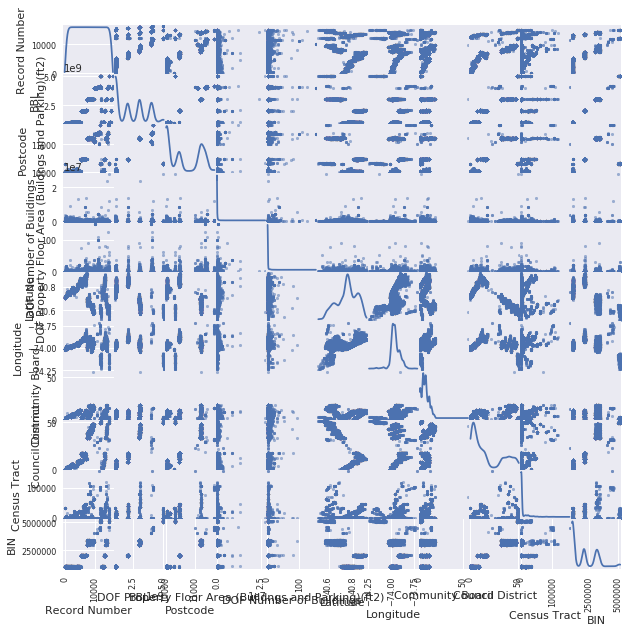

In [668]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')

##### Figure 1: Scatter matrix of dataset Water Data Disclosure

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [669]:
nrgnew=nrg[['BBL','Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' ]]

In [670]:
nrgnew.columns

Index(['BBL', 'Site EUI(kBtu/ft2)',
       'Reported Property Floor Area (Building(s)) (ft²)'],
      dtype='object')

In [671]:
#bsize

In [672]:
bsizenew = bsize[['BBL', 'UnitsRes', 'UnitsTotal', 'YearBuilt', 'geometry']]


In [673]:
bsizenew.columns.sort_values()

Index(['BBL', 'UnitsRes', 'UnitsTotal', 'YearBuilt', 'geometry'], dtype='object')

In [674]:
#leave
nrgnew.head()

BBL Site EUI(kBtu/ft2)  \
0  1.000410e+09                NaN   
1  4.021460e+09                NaN   
2  2.027620e+09                NaN   
3  1.006700e+09                NaN   
4  2.048300e+09                NaN   

  Reported Property Floor Area (Building(s)) (ft²)  
0                                           918919  
1                                              NaN  
2                                            64200  
3                                              NaN  
4                                            50000

In [675]:
#leave
bsizenew.head()

BBL  UnitsRes  UnitsTotal  YearBuilt  \
0  1.015450e+09        16          18       1920   
1  1.007238e+09        50          50       1914   
2  1.016800e+09        10          10       1910   
3  1.013850e+09        29          32       1928   
4  1.011970e+09        26          26       1900   

                                            geometry  
0  POLYGON ((997277.2344360352 221816.0936279297,...  
1  POLYGON ((984164.5626220703 211846.0704345703,...  
2  POLYGON ((1000742.195800781 227910.6640014648,...  
3  POLYGON ((994007.6885986328 219880.4284057617,...  
4  POLYGON ((992273.6849975586 224863.4904174805,...

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


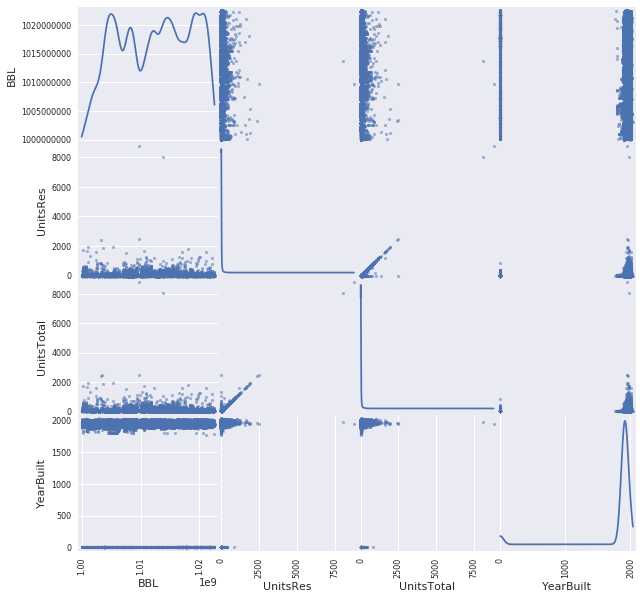

In [676]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsizenew, s=30, figsize=(10, 10), diagonal='kde')

##### Figure 2: Scatter matrix of PLUTO DATA

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [677]:
columns_to_numeric = [i for i in bsizenew.columns.values if i != 'version' and i != 'geometry']
bsizenew['BBL'] = pd.to_numeric(bsizenew['BBL'])
bsizenew.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


BBL  UnitsRes  UnitsTotal  YearBuilt  \
0  1.015450e+09        16          18       1920   
1  1.007238e+09        50          50       1914   
2  1.016800e+09        10          10       1910   
3  1.013850e+09        29          32       1928   
4  1.011970e+09        26          26       1900   

                                            geometry  
0  POLYGON ((997277.2344360352 221816.0936279297,...  
1  POLYGON ((984164.5626220703 211846.0704345703,...  
2  POLYGON ((1000742.195800781 227910.6640014648,...  
3  POLYGON ((994007.6885986328 219880.4284057617,...  
4  POLYGON ((992273.6849975586 224863.4904174805,...

In [678]:
nrgnew['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrgnew['Site EUI(kBtu/ft2)'], errors='coerce')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [679]:
nrgnew['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10]

(0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 5   NaN
 6   NaN
 7   NaN
 8   NaN
 9   NaN
 Name: Site EUI(kBtu/ft2), dtype: float64, 0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 5    1.002360e+09
 6    1.008370e+09
 7    1.001960e+09
 8    1.022240e+09
 9    1.011270e+09
 Name: BBL, dtype: float64)

In [680]:
##check that your conversion worked: e.g.
#nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10]
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


In [681]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrgnew['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [682]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrgnew['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [683]:
nrgnew.head()

BBL  Site EUI(kBtu/ft2)  \
0  1.000410e+09                 NaN   
1  4.021460e+09                 NaN   
2  2.027620e+09                 NaN   
3  1.006700e+09                 NaN   
4  2.048300e+09                 NaN   

  Reported Property Floor Area (Building(s)) (ft²)  
0                                           918919  
1                                              NaN  
2                                            64200  
3                                              NaN  
4                                            50000

In [684]:
#leave
#merge in a geodataframe for mapping, and if you want in a regular DF for analysis (more portable)
bblnrgdataGPD = bsizenew.merge(nrgnew, on='BBL')
type(bblnrgdataGPD)

geopandas.geodataframe.GeoDataFrame

In [685]:
bblnrgdataGPD.head()

BBL  UnitsRes  UnitsTotal  YearBuilt  \
0  1.007238e+09        50          50       1914   
1  1.013850e+09        29          32       1928   
2  1.021740e+09        72          72       1923   
3  1.008830e+09       107         108       1931   
4  1.008570e+09       134         138       1910   

                                            geometry  Site EUI(kBtu/ft2)  \
0  POLYGON ((984164.5626220703 211846.0704345703,...                68.7   
1  POLYGON ((994007.6885986328 219880.4284057617,...                87.4   
2  POLYGON ((1004080.155029297 252930.9956054688,...               140.4   
3  POLYGON ((989337.639831543 209686.7838134766, ...                96.5   
4  POLYGON ((988035.3540039062 210290.9854125977,...                36.4   

  Reported Property Floor Area (Building(s)) (ft²)  
0                                            95844  
1                                           206989  
2                                            52920  
3                                            98359  
4                                           154000

In [686]:
bblnrgdata = nrgnew.merge(bsizenew, on='BBL')

In [687]:
type(bblnrgdata)

pandas.core.frame.DataFrame

In [688]:
print(bblnrgdata.shape)
bblnrgdata.head()

(6438, 7)


BBL  Site EUI(kBtu/ft2)  \
0  1.006700e+09                 NaN   
1  1.004370e+09                 NaN   
2  1.013110e+09               125.4   
3  1.009220e+09                 NaN   
4  1.007400e+09                 NaN   

  Reported Property Floor Area (Building(s)) (ft²)  UnitsRes  UnitsTotal  \
0                                              NaN         0           1   
1                                              NaN         0           4   
2                                           330000         0          56   
3                                              NaN       148         148   
4                                            68329         0           1   

   YearBuilt                                           geometry  
0       1987  POLYGON ((982544.9470214844 212642.966796875, ...  
1       1920  POLYGON ((988632.9398193359 204610.9329833984,...  
2       1977  POLYGON ((993141.1744384766 216172.3948364258,...  
3       1963  POLYGON ((989369.5852050781 206338.7576293945,...  
4       1920  POLYGON ((983418.6008300781 209632.8702392578,...

In [689]:
#bblnrgdata.drop('geometry',axis=1, inplace=True)
bblnrgdata.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)':'Reported Property Floor Area'}, inplace=True)
bblnrgdata.head()

BBL  Site EUI(kBtu/ft2) Reported Property Floor Area  UnitsRes  \
0  1.006700e+09                 NaN                          NaN         0   
1  1.004370e+09                 NaN                          NaN         0   
2  1.013110e+09               125.4                       330000         0   
3  1.009220e+09                 NaN                          NaN       148   
4  1.007400e+09                 NaN                        68329         0   

   UnitsTotal  YearBuilt                                           geometry  
0           1       1987  POLYGON ((982544.9470214844 212642.966796875, ...  
1           4       1920  POLYGON ((988632.9398193359 204610.9329833984,...  
2          56       1977  POLYGON ((993141.1744384766 216172.3948364258,...  
3         148       1963  POLYGON ((989369.5852050781 206338.7576293945,...  
4           1       1920  POLYGON ((983418.6008300781 209632.8702392578,...

In [690]:
bblnrgdataGPD.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)':'Floor Area'}, inplace=True)
bblnrgdataGPD.head(1)

BBL  UnitsRes  UnitsTotal  YearBuilt  \
0  1.007238e+09        50          50       1914   

                                            geometry  Site EUI(kBtu/ft2)  \
0  POLYGON ((984164.5626220703 211846.0704345703,...                68.7   

  Floor Area  
0      95844

In [691]:
bblnrgdata['UnitsRes'].shape

(6438,)

In [692]:
bblnrgdata=bblnrgdata.loc[bblnrgdata['UnitsRes']>0,:]

In [693]:
bblnrgdata.head()

BBL  Site EUI(kBtu/ft2) Reported Property Floor Area  UnitsRes  \
3   1.009220e+09                 NaN                          NaN       148   
6   1.008830e+09                 NaN                        58456         2   
17  1.020930e+09                 NaN                        78678        65   
19  1.021420e+09               137.7                        64806        54   
20  1.021750e+09               103.2                        62839        75   

    UnitsTotal  YearBuilt                                           geometry  
3          148       1963  POLYGON ((989369.5852050781 206338.7576293945,...  
6            3       1910  POLYGON ((989130.5303955078 209596.8801879883,...  
17          71       1915  POLYGON ((998021.8062133789 240809.2883911133,...  
19          62       1924  POLYGON ((1001098.760620117 246912.0266113281,...  
20          85       1920  POLYGON ((1004289.818237305 253753.9874267578,...

# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [694]:
bblnrgdataGPD=bblnrgdataGPD.loc[bblnrgdataGPD['UnitsRes']>0,:]
###WHy doesnt this work:::: bblnrgdataGPD.replace('0', np.nan) ???????????????????????????????????????????
bblnrgdataGPD.replace('-', np.nan)
bblnrgdataGPD.dropna(inplace=True)

In [695]:
bblnrgdataGPD['Floor Area']=pd.to_numeric(bblnrgdataGPD['Floor Area'],errors='coerce')
bblnrgdataGPD['logarea']=np.log10(bblnrgdataGPD['Floor Area']+0.1)

In [696]:
bblnrgdataGPD['logunits']=np.log10(bblnrgdataGPD['UnitsRes']+0.1)

In [697]:
bblnrgdataGPD['Site EUI(kBtu/ft2)']=pd.to_numeric(bblnrgdataGPD['Site EUI(kBtu/ft2)'],errors='coerce')
bblnrgdataGPD['lognrg']=np.log10(bblnrgdataGPD['Site EUI(kBtu/ft2)']+0.1)

In [698]:
bblnrgdataGPD.head()

BBL  UnitsRes  UnitsTotal  YearBuilt  \
0  1.007238e+09        50          50       1914   
1  1.013850e+09        29          32       1928   
2  1.021740e+09        72          72       1923   
3  1.008830e+09       107         108       1931   
4  1.008570e+09       134         138       1910   

                                            geometry  Site EUI(kBtu/ft2)  \
0  POLYGON ((984164.5626220703 211846.0704345703,...                68.7   
1  POLYGON ((994007.6885986328 219880.4284057617,...                87.4   
2  POLYGON ((1004080.155029297 252930.9956054688,...               140.4   
3  POLYGON ((989337.639831543 209686.7838134766, ...                96.5   
4  POLYGON ((988035.3540039062 210290.9854125977,...                36.4   

   Floor Area   logarea  logunits    lognrg  
0       95844  4.981565  1.699838  1.837588  
1      206989  5.315947  1.463893  1.942008  
2       52920  4.723621  1.857935  2.147676  
3       98359  4.992815  2.029789  1.984977  
4      154000  5.187521  2.127429  1.562293

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


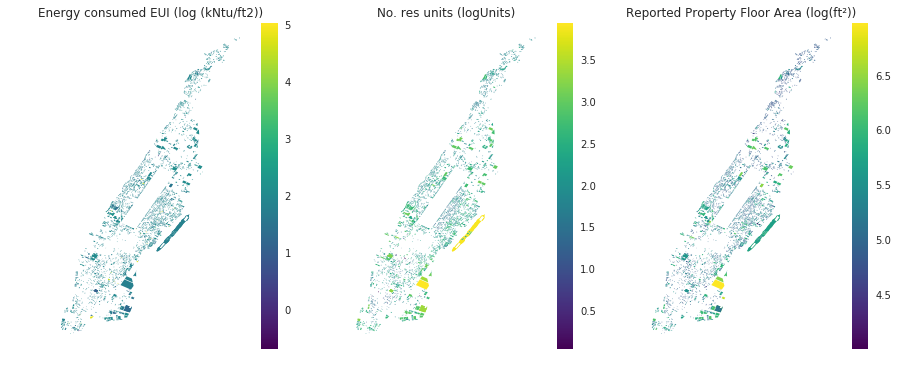

In [699]:
fig = pl.figure(figsize=(15,6))
ax = fig.add_subplot(131)
bblnrgdataGPD.plot(column="lognrg", ax=ax, legend=True, label=True,cmap='viridis')
ax.set_title("Energy consumed EUI (log (kNtu/ft2))")
ax.axis('off')

ax = fig.add_subplot(132)
bblnrgdataGPD.plot(column="logunits", ax=ax, label=True, legend=True,cmap='viridis')
ax.set_title("No. res units (logUnits)")
ax.axis('off')

ax = fig.add_subplot(133)
bblnrgdataGPD.plot(column="logarea", ax=ax, label=True,legend=True,cmap='viridis')
ax.set_title("Reported Property Floor Area (log(ft²))")
ax.axis('off');

Figure 3: Energy consumed (left), No. of residential units (middle), and Reported Property Floor Area (right) in Manhattan

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [700]:
# Total energy column from the columns you have. Plot a column vs the other

In [701]:
bblnrgdata.head(1)

BBL  Site EUI(kBtu/ft2) Reported Property Floor Area  UnitsRes  \
3  1.009220e+09                 NaN                          NaN       148   

   UnitsTotal  YearBuilt                                           geometry  
3         148       1963  POLYGON ((989369.5852050781 206338.7576293945,...

In [702]:
bblnrgdata['Reported Property Floor Area']=pd.to_numeric(bblnrgdata['Reported Property Floor Area'],errors='coerce')

In [703]:
bblnrgdata['total energy']=bblnrgdata[\
    'Reported Property Floor Area'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)

In [704]:
#bblnrgdata['total units']=

(0, 100000000000.0)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


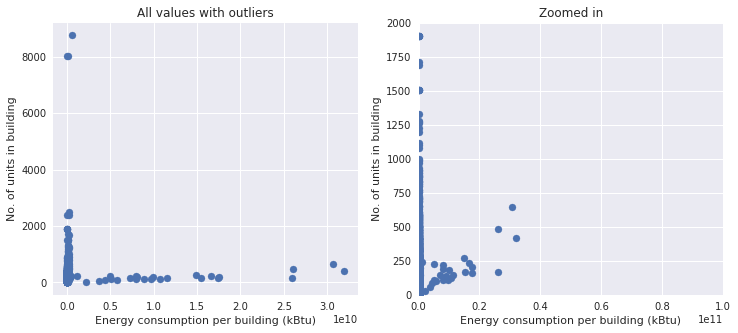

In [705]:
fig = plt.figure(figsize  = (12, 5))

#pl.scatter(bblnrgdata['total energy'],bblnrgdata['UnitsRes'])
ax1 = fig.add_subplot(121)
ax1.scatter(bblnrgdata['total energy'],bblnrgdata['UnitsRes'])
ax1.set_ylabel('No. of units in building')
ax1.set_xlabel('Energy consumption per building (kBtu)')
ax1.set_title('All values with outliers')

ax2 = fig.add_subplot(122)
ax2.scatter(bblnrgdata['total energy'],bblnrgdata['UnitsRes'])
ax2.set_ylabel('No. of units in building')
ax2.set_xlabel('Energy consumption per building (kBtu)')
ax2.set_title('Zoomed in')
ax2.set_ylim(1,2000)
ax2.set_xlim(0,1e11)

Figure 4: Energy consumption per building against number of units with all values (left) and zoomed in (right). There is a correlation observed if zooming in.

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





Text(0,0.5,'$log_{10}$(x)')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


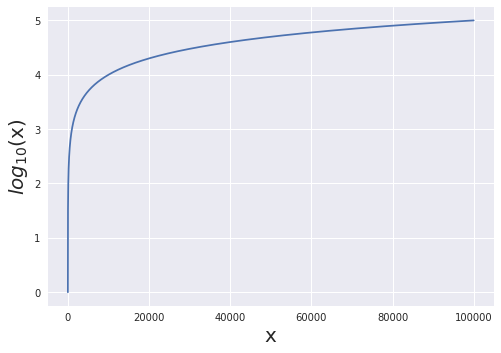

In [706]:
pl.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
pl.xlabel("x", fontsize=20)
pl.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


(1, 10000000000.0)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


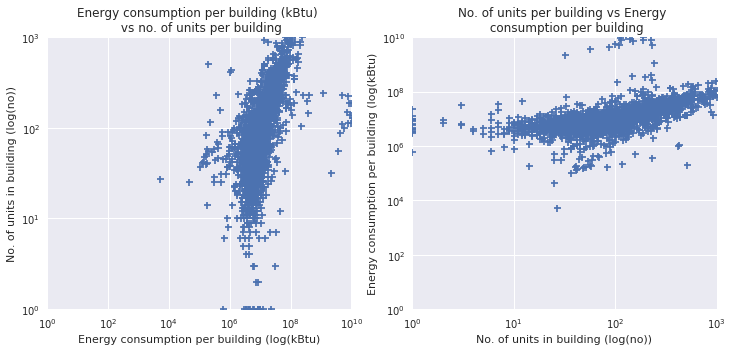

In [707]:
fig = plt.figure(figsize  = (12, 5))

#pl.scatter(bblnrgdata['total energy'],bblnrgdata['UnitsRes'])
ax1 = fig.add_subplot(121)
ax1.scatter(bblnrgdata['total energy'],bblnrgdata['UnitsRes'], marker='+')
ax1.set_xlabel('Energy consumption per building (log(kBtu)')
ax1.set_ylabel('No. of units in building (log(no))')
ax1.set_title('Energy consumption per building (kBtu) \n vs no. of units per building')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(1,(1000))
ax1.set_xlim(1,(1e10))

ax2 = fig.add_subplot(122)
ax2.scatter((bblnrgdata['UnitsRes']),(bblnrgdata['total energy']), marker='+')
ax2.set_xlabel('No. of units in building (log(no))')
ax2.set_ylabel('Energy consumption per building (log(kBtu)')
ax2.set_title('No. of units per building vs Energy \n consumption per building')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1,1000)
ax2.set_ylim(1,1e10)

###### Figure 6&7 : Energy consumption per building vs no. of units per building (left) and viceversa (right) plotted in log scale

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**

In [763]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [765]:
bblnrgdataCut = bblnrgdata.loc[(1000 < bblnrgdata['total energy']) & (bblnrgdata['total energy'] < 1e10) & \
                            (9 <= bblnrgdata.UnitsRes) & (bblnrgdata.UnitsRes < 1000),:]
bblnrgdataCut.describe()


BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
count  3.436000e+03         3436.000000                  3.436000e+03   
mean   1.013185e+09          272.166123                  1.676391e+05   
std    5.543539e+06         3391.077688                  2.031515e+05   
min    1.000078e+09            0.100000                  1.000000e+04   
25%    1.009160e+09           67.100000                  6.962675e+04   
50%    1.013684e+09           82.600000                  1.068920e+05   
75%    1.017213e+09          100.225000                  1.889168e+05   
max    1.022500e+09       106472.700000                  5.207812e+06   

          UnitsRes   UnitsTotal    YearBuilt  total energy     logunits  \
count  3436.000000  3436.000000  3436.000000  3.436000e+03  3436.000000   
mean    127.918219   131.433644  1944.521537  3.954972e+07     1.949571   
std     129.409720   131.790911    65.741994  4.300792e+08     0.364632   
min       9.000000    10.000000     0.000000  5.344000e+03     0.959041   
25%      52.000000    54.000000  1922.000000  5.728109e+06     1.716838   
50%      83.000000    86.000000  1931.000000  8.501492e+06     1.919601   
75%     155.000000   159.000000  1968.000000  1.530620e+07     2.190612   
max     995.000000   995.000000  2014.000000  9.926784e+09     2.997867   

            lognrg  total energy2  
count  3436.000000   3.436000e+03  
mean      1.897604   1.864784e+17  
std       0.288242   3.529345e+18  
min      -0.698970   2.855834e+07  
25%       1.827369   3.281124e+13  
50%       1.917506   7.227537e+13  
75%       2.001409   2.342798e+14  
max       5.027239   9.854104e+19

In [766]:
#bblnrgdata['logarea']=np.log10(bblnrgdata['Floor Area']+0.1)
bblnrgdataCut['logunits']=np.log10(bblnrgdataCut['UnitsRes']+0.1)
bblnrgdataCut['lognrg']=np.log10(bblnrgdataCut['Site EUI(kBtu/ft2)']+0.1)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [767]:
bblnrgdataCut=bblnrgdataCut.sort(columns='total energy')
bblnrgdataCut.head()


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
3795  1.019900e+09                 0.1                       53440.0   
3801  1.019900e+09                 0.9                       49668.0   
5727  1.012100e+09                 1.5                       70000.0   
5681  1.019450e+09                 2.2                       57148.0   
5735  1.021391e+09                 1.6                       84800.0   

      UnitsRes  UnitsTotal  YearBuilt  \
3795        27          27       1909   
3801        25          25       1910   
5727        37          37       1912   
5681        41          41       1920   
5735        42          42       1924   

                                               geometry  total energy  \
3795  POLYGON ((994066.3934326172 234073.4490356445,...        5344.0   
3801  POLYGON ((994172.2518310547 234473.0010375977,...       44701.2   
5727  POLYGON ((990639.5518188477 224677.9194335938,...      105000.0   
5681  POLYGON ((996276.6068115234 233306.432800293, ...      125725.6   
5735  POLYGON ((1000608.94543457 247926.2786254883, ...      135680.0   

      logunits    lognrg  total energy2  
3795  1.432969 -0.698970   2.855834e+07  
3801  1.399674  0.000000   1.998197e+09  
5727  1.569374  0.204120   1.102500e+10  
5681  1.613842  0.361728   1.580693e+10  
5735  1.624282  0.230449   1.840906e+10

In [768]:
bblnrgdata2=bblnrgdataCut.sort(columns='UnitsRes')
bblnrgdata2.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
2762  1.013910e+09                81.4                       45913.0   
5719  1.010340e+09               125.9                       57000.0   
367   1.004870e+09                48.5                       74536.0   
362   1.004838e+09                76.1                       58233.0   
1395  1.008928e+09                70.1                      148455.0   

      UnitsRes  UnitsTotal  YearBuilt  \
2762         9          10       1926   
5719         9          12       2009   
367          9          11       1900   
362          9          10       1900   
1395         9          10       2002   

                                               geometry  total energy  \
2762  POLYGON ((994075.791809082 221617.1296386719, ...     3737318.2   
5719  POLYGON ((987236.673828125 215541.5137939453, ...     7176300.0   
367   POLYGON ((983777.9840087891 202904.0914306641,...     3614996.0   
362   POLYGON ((984680.6887817383 202402.0137939453,...     4431531.3   
1395  POLYGON ((990630.8472290039 211634.500793457, ...    10406695.5   

      logunits    lognrg  total energy2  
2762  0.959041  1.911158   1.396755e+13  
5719  0.959041  2.100371   5.149928e+13  
367   0.959041  1.686636   1.306820e+13  
362   0.959041  1.881955   1.963847e+13  
1395  0.959041  1.846337   1.082993e+14

In [769]:
XUnitsRes_addconstantresult = sm.add_constant(bblnrgdata2.UnitsRes)
Xnrg_addconstantresult = sm.add_constant(bblnrgdataCut['Site EUI(kBtu/ft2)'])
Y1=bblnrgdataCut['UnitsRes']
Y2=bblnrgdata2['total energy']

In [770]:
XUnitsRes_addconstantresult.head()

const  UnitsRes
2762      1         9
5719      1         9
367       1         9
362       1         9
1395      1         9

In [771]:
Xnrg_addconstantresult.head()

const  Site EUI(kBtu/ft2)
3795    1.0                 0.1
3801    1.0                 0.9
5727    1.0                 1.5
5681    1.0                 2.2
5735    1.0                 1.6

In [772]:
bblnrgdataCut.head()

BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
3795  1.019900e+09                 0.1                       53440.0   
3801  1.019900e+09                 0.9                       49668.0   
5727  1.012100e+09                 1.5                       70000.0   
5681  1.019450e+09                 2.2                       57148.0   
5735  1.021391e+09                 1.6                       84800.0   

      UnitsRes  UnitsTotal  YearBuilt  \
3795        27          27       1909   
3801        25          25       1910   
5727        37          37       1912   
5681        41          41       1920   
5735        42          42       1924   

                                               geometry  total energy  \
3795  POLYGON ((994066.3934326172 234073.4490356445,...        5344.0   
3801  POLYGON ((994172.2518310547 234473.0010375977,...       44701.2   
5727  POLYGON ((990639.5518188477 224677.9194335938,...      105000.0   
5681  POLYGON ((996276.6068115234 233306.432800293, ...      125725.6   
5735  POLYGON ((1000608.94543457 247926.2786254883, ...      135680.0   

      logunits    lognrg  total energy2  
3795  1.432969 -0.698970   2.855834e+07  
3801  1.399674  0.000000   1.998197e+09  
5727  1.569374  0.204120   1.102500e+10  
5681  1.613842  0.361728   1.580693e+10  
5735  1.624282  0.230449   1.840906e+10

In [773]:
print(Y2.shape,XUnitsRes_addconstantresult.shape)

(3436,) (3436, 2)


In [774]:
lm1 = smf.OLS(Y1,Xnrg_addconstantresult).fit()
predicted1 = lm1.predict()
print(lm1.summary())

lm2 = smf.OLS(Y2,XUnitsRes_addconstantresult).fit()
predicted2 = lm2.predict()
print(lm2.summary())



                            OLS Regression Results                            
Dep. Variable:               UnitsRes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03098
Date:                Wed, 28 Nov 2018   Prob (F-statistic):              0.860
Time:                        22:25:20   Log-Likelihood:                -21584.
No. Observations:                3436   AIC:                         4.317e+04
Df Residuals:                    3434   BIC:                         4.318e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                127.8870      2

In [775]:
predicted1

array([ 127.88703185,  127.88712356,  127.88719234, ...,  137.45258186,
        131.62935398,  130.70921701])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


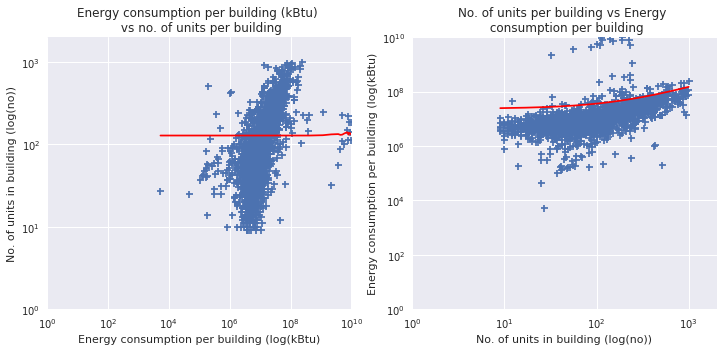

In [777]:
fig = plt.figure(figsize  = (12, 5))

#pl.scatter(bblnrgdata['total energy'],bblnrgdata['UnitsRes'])
ax1 = fig.add_subplot(121)
ax1.scatter(bblnrgdataCut['total energy'],bblnrgdataCut['UnitsRes'], marker='+')
ax1.set_xlabel('Energy consumption per building (log(kBtu)')
ax1.set_ylabel('No. of units in building (log(no))')
ax1.set_title('Energy consumption per building (kBtu) \n vs no. of units per building')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(1,(2000))
ax1.set_xlim(1,(1e10))
ax1.plot(bblnrgdataCut['total energy'],predicted1,'r-')

ax2 = fig.add_subplot(122)
ax2.scatter((bblnrgdata2['UnitsRes']),(bblnrgdata2['total energy']), marker='+')
ax2.set_xlabel('No. of units in building (log(no))')
ax2.set_ylabel('Energy consumption per building (log(kBtu)')
ax2.set_title('No. of units per building vs Energy \n consumption per building')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1,2000)
ax2.set_ylim(1,1e10)
ax2.plot((bblnrgdata2['UnitsRes']),predicted2,'r-')

###### Figure 8: Energy consumption per building vs no. of units per building (left) and viceversa (right) plotted in log scale with a line fit

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**answer: Units cause energy consumption **

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

### Units vs Energy
###### Using Units as IV yields:

R-squared = 0.000
Log-Likelihood:                -24983.

### Energy against Units
###### Using Units as DV yields:

R-squared:                       0.001
Log-Likelihood:                -78574
    
#### Log-Likelihood is higher (closer to zero) for the Units as an Independet Variable (IV). Log-Likelyhood closer to one is a measure of a better fit. Units as IV has a better fit (even though this doesn't make sense).

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


In [867]:
bblnrgdataCut.head(3)

BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
3795  1.019900e+09                 0.1                       53440.0   
3801  1.019900e+09                 0.9                       49668.0   
5727  1.012100e+09                 1.5                       70000.0   

      UnitsRes  UnitsTotal  YearBuilt  \
3795        27          27       1909   
3801        25          25       1910   
5727        37          37       1912   

                                               geometry  total energy  \
3795  POLYGON ((994066.3934326172 234073.4490356445,...        5344.0   
3801  POLYGON ((994172.2518310547 234473.0010375977,...       44701.2   
5727  POLYGON ((990639.5518188477 224677.9194335938,...      105000.0   

      logunits   lognrg  total energy2          nrg2       nrg   lognrg2  
3795  1.432969 -0.69897   2.855834e+07  2.855834e+07    5344.0  0.488559  
3801  1.399674  0.00000   1.998197e+09  1.998197e+09   44701.2  0.000000  
5727  1.569374  0.20412   1.102500e+10  1.102500e+10  105000.0  0.041665

In [868]:
bblnrgdataCut=bblnrgdataCut.sort(columns='total energy')
bblnrgdataCut.head()
bblnrgdata2=bblnrgdataCut.sort(columns='UnitsRes')
bblnrgdata2.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
2762  1.013910e+09                81.4                       45913.0   
5719  1.010340e+09               125.9                       57000.0   
367   1.004870e+09                48.5                       74536.0   
362   1.004838e+09                76.1                       58233.0   
1395  1.008928e+09                70.1                      148455.0   

      UnitsRes  UnitsTotal  YearBuilt  \
2762         9          10       1926   
5719         9          12       2009   
367          9          11       1900   
362          9          10       1900   
1395         9          10       2002   

                                               geometry  total energy  \
2762  POLYGON ((994075.791809082 221617.1296386719, ...     3737318.2   
5719  POLYGON ((987236.673828125 215541.5137939453, ...     7176300.0   
367   POLYGON ((983777.9840087891 202904.0914306641,...     3614996.0   
362   POLYGON ((984680.6887817383 202402.0137939453,...     4431531.3   
1395  POLYGON ((990630.8472290039 211634.500793457, ...    10406695.5   

      logunits    lognrg  total energy2          nrg2         nrg   lognrg2  
2762  0.959041  1.911158   1.396755e+13  1.396755e+13   3737318.2  3.652523  
5719  0.959041  2.100371   5.149928e+13  5.149928e+13   7176300.0  4.411556  
367   0.959041  1.686636   1.306820e+13  1.306820e+13   3614996.0  2.844742  
362   0.959041  1.881955   1.963847e+13  1.963847e+13   4431531.3  3.541755  
1395  0.959041  1.846337   1.082993e+14  1.082993e+14  10406695.5  3.408961

In [869]:
bblnrgdataCut['nrg']=bblnrgdataCut['total energy']
bblnrgdataCut['nrg2']=bblnrgdataCut['nrg']**2

In [870]:
bblnrgdata2['UnitsRes2']=bblnrgdata2['UnitsRes']**2

In [871]:
bblnrgdataCut['lognrg2']=bblnrgdataCut['lognrg']**2
bblnrgdataCut.head(3)

BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
3795  1.019900e+09                 0.1                       53440.0   
3801  1.019900e+09                 0.9                       49668.0   
5727  1.012100e+09                 1.5                       70000.0   

      UnitsRes  UnitsTotal  YearBuilt  \
3795        27          27       1909   
3801        25          25       1910   
5727        37          37       1912   

                                               geometry  total energy  \
3795  POLYGON ((994066.3934326172 234073.4490356445,...        5344.0   
3801  POLYGON ((994172.2518310547 234473.0010375977,...       44701.2   
5727  POLYGON ((990639.5518188477 224677.9194335938,...      105000.0   

      logunits   lognrg  total energy2          nrg2       nrg   lognrg2  
3795  1.432969 -0.69897   2.855834e+07  2.855834e+07    5344.0  0.488559  
3801  1.399674  0.00000   1.998197e+09  1.998197e+09   44701.2  0.000000  
5727  1.569374  0.20412   1.102500e+10  1.102500e+10  105000.0  0.041665

In [872]:
bblnrgdata2['logunits2']=bblnrgdata2.logunits**2
bblnrgdata2.head(3)

BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
2762  1.013910e+09                81.4                       45913.0   
5719  1.010340e+09               125.9                       57000.0   
367   1.004870e+09                48.5                       74536.0   

      UnitsRes  UnitsTotal  YearBuilt  \
2762         9          10       1926   
5719         9          12       2009   
367          9          11       1900   

                                               geometry  total energy  \
2762  POLYGON ((994075.791809082 221617.1296386719, ...     3737318.2   
5719  POLYGON ((987236.673828125 215541.5137939453, ...     7176300.0   
367   POLYGON ((983777.9840087891 202904.0914306641,...     3614996.0   

      logunits    lognrg  total energy2          nrg2        nrg   lognrg2  \
2762  0.959041  1.911158   1.396755e+13  1.396755e+13  3737318.2  3.652523   
5719  0.959041  2.100371   5.149928e+13  5.149928e+13  7176300.0  4.411556   
367   0.959041  1.686636   1.306820e+13  1.306820e+13  3614996.0  2.844742   

      UnitsRes2  logunits2  
2762         81    0.91976  
5719         81    0.91976  
367          81    0.91976

In [873]:
columnste = ['lognrg', 'lognrg2']

In [874]:
columnsur = ['logunits', 'logunits']

In [875]:
OLS5 = smf.ols(formula='nrg ~ UnitsRes2 + UnitsRes', data=bblnrgdata2).fit()
print(OLS5.summary())

                            OLS Regression Results                            
Dep. Variable:                    nrg   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.265
Date:                Wed, 28 Nov 2018   Prob (F-statistic):             0.0141
Time:                        22:56:20   Log-Likelihood:                -73177.
No. Observations:                3436   AIC:                         1.464e+05
Df Residuals:                    3433   BIC:                         1.464e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5.668e+06   1.39e+07      0.406      0.6

In [876]:
OLS3 = smf.ols(formula='lognrg ~ logunits2 + logunits', data=bblnrgdata2).fit()
print(OLS3.summary())

                            OLS Regression Results                            
Dep. Variable:                 lognrg   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     16.03
Date:                Wed, 28 Nov 2018   Prob (F-statistic):           1.18e-07
Time:                        22:56:20   Log-Likelihood:                -584.77
No. Observations:                3436   AIC:                             1176.
Df Residuals:                    3433   BIC:                             1194.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.6187      0.103     15.787      0.0

In [877]:
OLS6 = smf.ols(formula='UnitsRes ~ nrg + nrg2', data=bblnrgdataCut).fit()
print(OLS5.summary())

                            OLS Regression Results                            
Dep. Variable:                    nrg   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.265
Date:                Wed, 28 Nov 2018   Prob (F-statistic):             0.0141
Time:                        22:56:21   Log-Likelihood:                -73177.
No. Observations:                3436   AIC:                         1.464e+05
Df Residuals:                    3433   BIC:                         1.464e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5.668e+06   1.39e+07      0.406      0.6

In [878]:
OLS4 = smf.ols(formula='logunits ~ lognrg2 + lognrg', data=bblnrgdataCut).fit()
print(OLS4.summary())

                            OLS Regression Results                            
Dep. Variable:               logunits   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     16.08
Date:                Wed, 28 Nov 2018   Prob (F-statistic):           1.12e-07
Time:                        22:56:22   Log-Likelihood:                -1392.5
No. Observations:                3436   AIC:                             2791.
Df Residuals:                    3433   BIC:                             2809.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.6463      0.070     23.534      0.0

In [879]:
OLS3.predict(bblnrgdata2)

array([ 1.79227483,  1.79227483,  1.79227483, ...,  1.94230946,
        1.94231393,  1.94231832])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


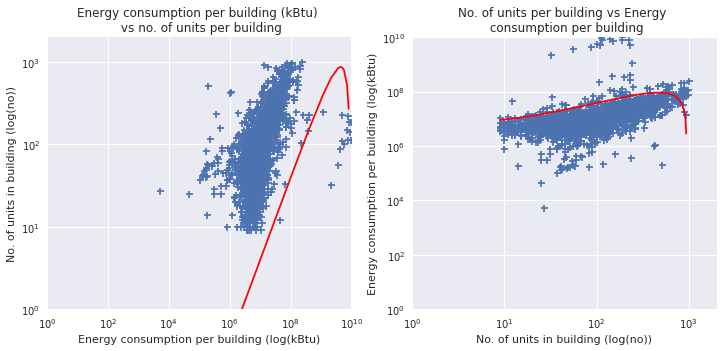

In [883]:
fig = plt.figure(figsize  = (12, 5))

#pl.scatter(bblnrgdata['total energy'],bblnrgdata['UnitsRes'])
ax1 = fig.add_subplot(121)
ax1.scatter(bblnrgdataCut['total energy'],bblnrgdataCut['UnitsRes'], marker='+')
ax1.set_xlabel('Energy consumption per building (log(kBtu)')
ax1.set_ylabel('No. of units in building (log(no))')
ax1.set_title('Energy consumption per building (kBtu) \n vs no. of units per building')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(1,(2000))
ax1.set_xlim(1,(1e10))
ax1.plot(bblnrgdataCut['total energy'],OLS6.predict(bblnrgdataCut),'r-')

ax2 = fig.add_subplot(122)
ax2.scatter((bblnrgdata2['UnitsRes']),(bblnrgdata2['total energy']), marker='+')
ax2.set_xlabel('No. of units in building (log(no))')
ax2.set_ylabel('Energy consumption per building (log(kBtu)')
ax2.set_title('No. of units per building vs Energy \n consumption per building')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1,2000)
ax2.set_ylim(1,1e10)
ax2.plot((bblnrgdata2['UnitsRes']),OLS5.predict(bblnrgdata2),'r-')

###### Figure 9: Energy consumption per building vs no. of units per building (left) and viceversa (right) plotted in log scale with a polyline fit

# calculate the chi square and likelihood of your model

## Define a chisquare function

In [884]:
#leave
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    ...    

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [885]:
bblnrgdataCut.head(2)

BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
3795  1.019900e+09                 0.1                       53440.0   
3801  1.019900e+09                 0.9                       49668.0   

      UnitsRes  UnitsTotal  YearBuilt  \
3795        27          27       1909   
3801        25          25       1910   

                                               geometry  total energy  \
3795  POLYGON ((994066.3934326172 234073.4490356445,...        5344.0   
3801  POLYGON ((994172.2518310547 234473.0010375977,...       44701.2   

      logunits   lognrg  total energy2          nrg2      nrg   lognrg2  
3795  1.432969 -0.69897   2.855834e+07  2.855834e+07   5344.0  0.488559  
3801  1.399674  0.00000   1.998197e+09  1.998197e+09  44701.2  0.000000

In [908]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#errors on the measured quantities
bblnrgdataCut['errorsnrg'] = np.sqrt(bblnrgdataCut['Site EUI(kBtu/ft2)']**2 + \
                                     bblnrgdataCut['Reported Property Floor Area']**2)
bblnrgdataCut['errorslognrg'] = bblnrgdataCut['errorsnrg']/(bblnrgdataCut['nrg']*np.log(10))


# better WOULD BE to calculate each error and add in quadrature: sqrt(1/A + 1/B) which becomes
#errorsnrg = np.sqrt(1.0 / bblnrgdataCut['Reported Property Floor Area'] + 1.0 / bblnrgdataCut['Site EUI(kBtu/ft2)'])
#but this leads to insane error values (insanely small)

## Assume count statistics in the number of units as well
bblnrgdataCut['errorsunits'] = np.sqrt(bblnrgdataCut['UnitsRes'])
bblnrgdataCut['errorslogunits'] = bblnrgdataCut['errorsunits']/(bblnrgdataCut['UnitsRes']*np.log(10))

## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


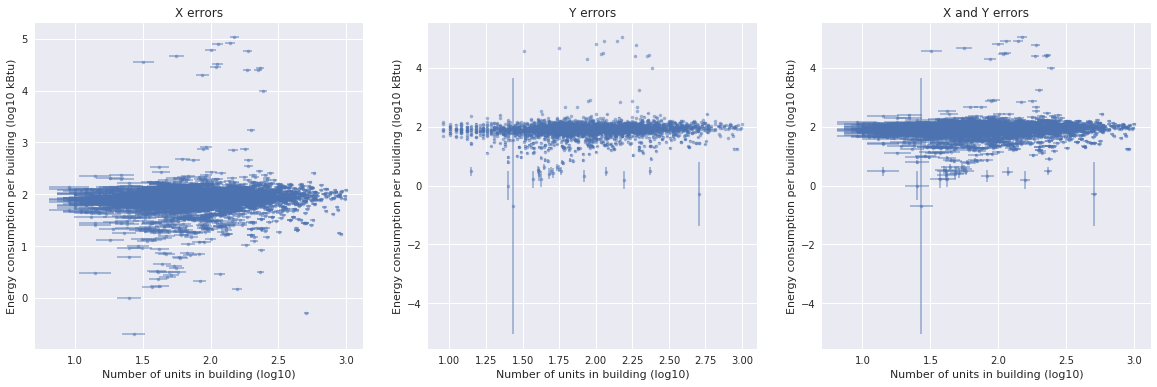

In [910]:
fig = plt.figure(figsize = (20, 6))

bblnrgdataCut.sort_values('UnitsRes', inplace=True)
ax1 = fig.add_subplot(131)
ax1.errorbar(x=bblnrgdataCut.logunits, y=bblnrgdataCut.lognrg, 
            xerr=bblnrgdataCut.errorslogunits, fmt='.',
            alpha=0.5)
ax1.set_ylabel('Energy consumption per building (log10 kBtu)')
ax1.set_xlabel('Number of units in building (log10)')
ax1.set_title('X errors')

bblnrgdataCut.sort_values('UnitsTotal', inplace=True)
ax2 = fig.add_subplot(132)
ax2.errorbar(x=bblnrgdataCut.logunits, y=bblnrgdataCut.lognrg, 
            yerr=bblnrgdataCut.errorslognrg, fmt='.',
            alpha=0.5)
ax2.set_ylabel('Energy consumption per building (log10 kBtu)')
ax2.set_xlabel('Number of units in building (log10)')
ax2.set_title('Y errors')

bblnrgdataCut.sort_values('UnitsTotal', inplace=True)
ax3 = fig.add_subplot(133)
ax3.errorbar(x=bblnrgdataCut.logunits, y=bblnrgdataCut.lognrg,
             xerr=bblnrgdataCut.errorslogunits,
             yerr=bblnrgdataCut.errorslognrg, fmt='.',
             alpha=0.5)
ax3.set_ylabel('Energy consumption per building (log10 kBtu)')
ax3.set_xlabel('Number of units in building (log10)')
ax3.set_title('X and Y errors')

plt.show()

Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

In [911]:
# import matplotlib.pyplot as plt
### NOTE TO SELF: HOW TO RUN THIS CODE?????????
# #I could also include errors for number of units
# fig2 = plt.figure(constrained_layout=True, figsize=(15,15))

# gs1 = gridspec.GridSpec(3, 3, figure=fig2)
# gs1.update(left=0.68, right=0.68, wspace=0.2)


# ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
# ax1.errorbar(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal), 
#             yerr=bblnrgdataCut.errorsunits, fmt='.',
#             alpha=0.5)
# ax1.set_ylabel("log10 of Units", fontsize=15)
# ax1.set_xlabel("log10 Energy", fontsize=15)
# pl.suptitle("Total units in building as function of Energy")


# ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
# ax2.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
#             yerr=bblnrgdataCut.errorsnrg, fmt='.',
#             alpha=0.5)
# ax2.set_xlabel("log10 of Units", fontsize=15)
# ax2.set_ylabel("log10 Energy", fontsize=15)

# ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
# ax4.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
#             yerr=bblnrgdataCut.errorsnrg,
#            xerr=bblnrgdataCut.errorsunits, alpha=0.5, fmt='.')
# ax4.set_xlabel("log10 of Units", fontsize=15)
# ax4.set_ylabel("log10 Energy", fontsize=15)
# ax4.set_ylim(5,11)

# print ("The largest error bar is for")
# bblnrgdataCut[bblnrgdataCut.errorsnrg == bblnrgdataCut.errorsnrg.max()]


Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [915]:
bblnrgdataCut.head()

BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
2762  1.013910e+09                81.4                       45913.0   
362   1.004838e+09                76.1                       58233.0   
1395  1.008928e+09                70.1                      148455.0   
3841  1.020070e+09               120.6                       14280.0   
4571  1.020110e+09                62.9                       12680.0   

      UnitsRes  UnitsTotal  YearBuilt  \
2762         9          10       1926   
362          9          10       1900   
1395         9          10       2002   
3841        10          10       1910   
4571        10          10       1900   

                                               geometry  total energy  \
2762  POLYGON ((994075.791809082 221617.1296386719, ...     3737318.2   
362   POLYGON ((984680.6887817383 202402.0137939453,...     4431531.3   
1395  POLYGON ((990630.8472290039 211634.500793457, ...    10406695.5   
3841  POLYGON ((1000877.430419922 236918.1813964844,...     1722168.0   
4571  POLYGON ((1001019.768981934 237913.1090087891,...      797572.0   

      logunits    lognrg  total energy2          nrg2         nrg   lognrg2  \
2762  0.959041  1.911158   1.396755e+13  1.396755e+13   3737318.2  3.652523   
362   0.959041  1.881955   1.963847e+13  1.963847e+13   4431531.3  3.541755   
1395  0.959041  1.846337   1.082993e+14  1.082993e+14  10406695.5  3.408961   
3841  1.004321  2.081707   2.965863e+12  2.965863e+12   1722168.0  4.333505   
4571  1.004321  1.799341   6.361211e+11  6.361211e+11    797572.0  3.237626   

          errorsnrg  errorslogNrg  errorsunits  errorslogUnits  errorslognrg  \
2762   45913.072158      0.005335     3.000000        0.144765      0.005335   
362    58233.049724      0.005707     3.000000        0.144765      0.005707   
1395  148455.016551      0.006195     3.000000        0.144765      0.006195   
3841   14280.509247      0.003601     3.162278        0.137336      0.003601   
4571   12680.156009      0.006905     3.162278        0.137336      0.006905   

      errorslogunits  
2762        0.144765  
362         0.144765  
1395        0.144765  
3841        0.137336  
4571        0.137336

In [916]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = len(bblnrgdataCut)
print ("degrees of freedom:" , dof)

degrees of freedom: 3436


In [913]:
bblnrgdataCut.shape

(3436, 20)

### Compare the models using the  chi square:
discuss

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

Figure 10: ...

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


LR = ...
**reject / not reject...**

## EC 1 Plotting the likelihood surface (assuming gaussian statistics)

when you assume Gaussian statistics the log likelihood is the chi square, so you can plot the chi square from the function you created earlier!

* choose a reasonable range of a, b, and c for your parameters. 
* calculate the chisquare for each value in the range: this can be done in a nested for loop
* save the value of the chi square and plot it as a surface

in pylab you can plot surfaces with pl.imshow()


### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that maximizing the log likelihood is the same as minimizing the chi square).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values
plot is for 
    - chi square calculated with no errors (i.e. sum of residuals squared)
    - chi squared with errors
    
compare the surfaces

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


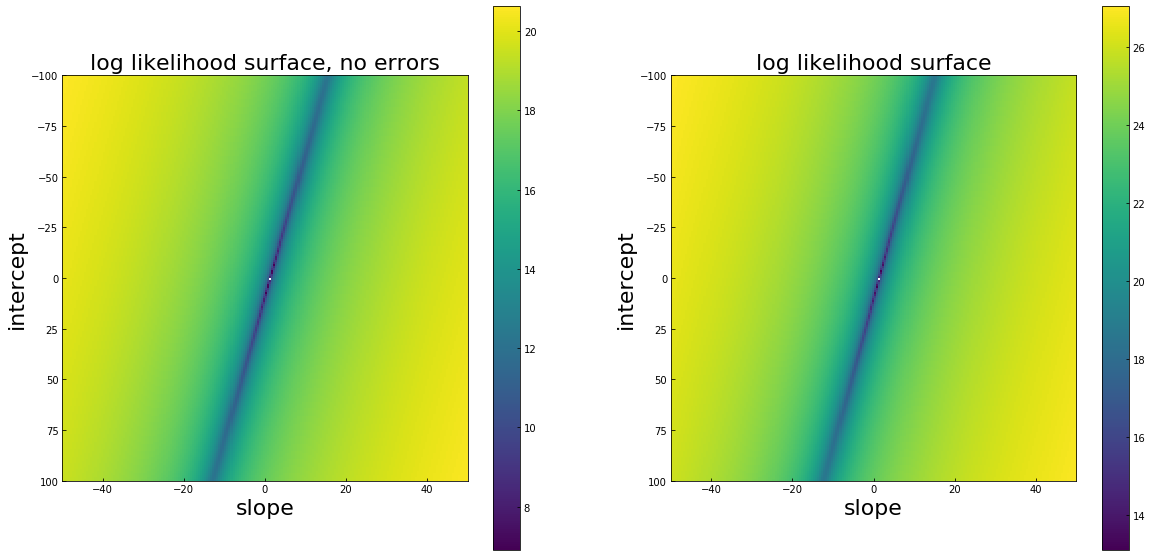

In [124]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title ("log likelihood surface, no errors", fontsize = 22)
pl.imshow(np.log(resids_noerror), extent = [-50,50,100,-100], aspect=0.5)
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar()

ax2 = fig.add_subplot(122)
ax2.set_title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(resids), extent = [-50,50,100,-100], aspect=0.5)
ax2.set_xlabel('slope', fontsize = 22)
ax2.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 11: ...

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


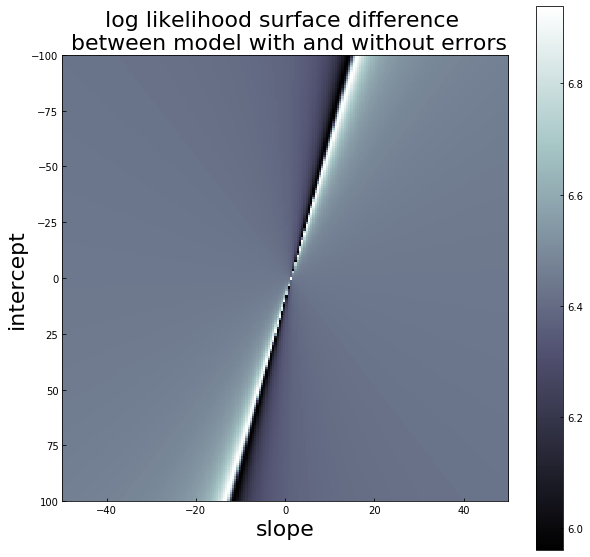

In [125]:
#leave
#plotting the difference between the 2 likelihood surfaces to see if the minimum is in the right place
ax1 = pl.figure(figsize=(10,10)).add_subplot(111)
ax1.set_title ("log likelihood surface difference \n between model with and without errors", fontsize = 22)
pl.imshow(np.abs(np.log(resids) - np.log(resids_noerror)), extent = [-50,50,100,-100], aspect=0.5, cmap='bone')
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 12: ...

# EXTRA CREDIT: a plot of anything related to these data

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda/envs/GEOP/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
//anaconda/envs/GEOP/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


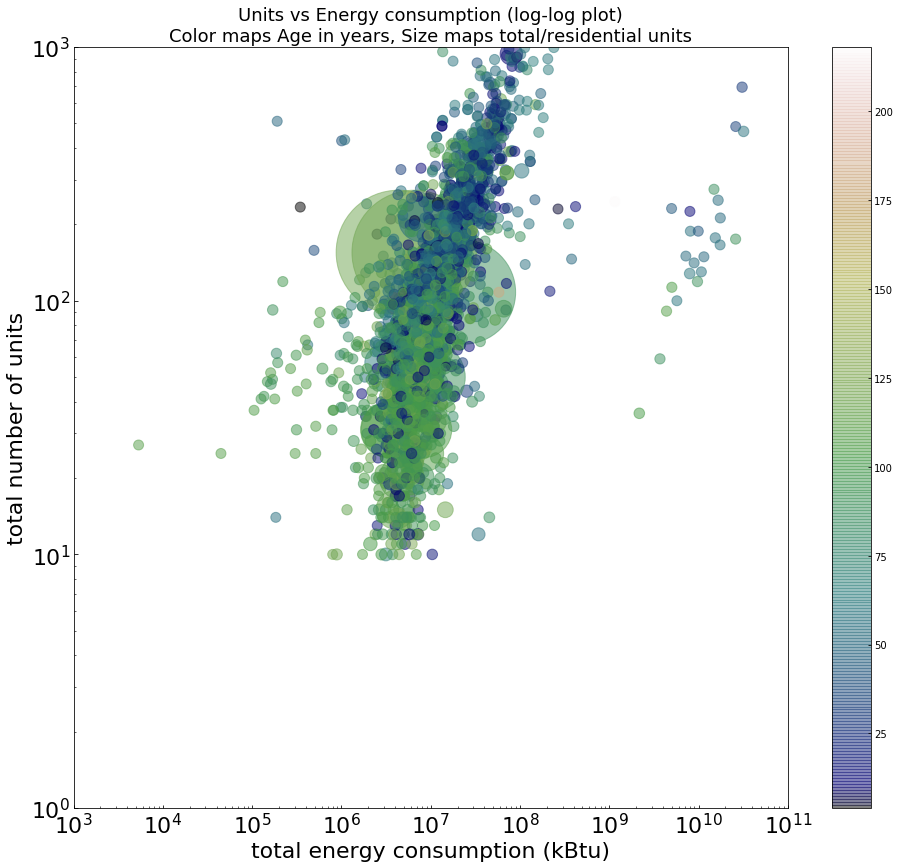

In [126]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
bblnrgdataCut['YearBuilt'][bblnrgdataCut['YearBuilt']<1800]=1800

bblnrgdataCut.plot(kind='scatter', x='nrg', y='UnitsTotal', 
                fontsize=22, colormap='gist_earth', alpha = 0.5, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), ax = ax,
                c= dt.datetime.today().year - bblnrgdataCut['YearBuilt'], 
                s=bblnrgdataCut['UnitsTotal']/bblnrgdataCut['UnitsRes'] * 100)
pl.title('Units vs Energy consumption (log-log plot)\nColor maps Age in years, Size maps total/residential units', 
         fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22);


Figure 13: Plot of Number of Units as a function of energy consumption for all NYC buildings with self reported energy consumption in the Local Law 84 database. The color of each datapoint representes the age: darker colors are buildings of more recent construction. The size of the mark represents the inverse of the fraction of residential units in the building (large datapoints indicate a small fraction of residential units, i.e. a comercial building). 

There is a weak color gradient where younger buildings dominate the higher portion of the plot. This could be interpreted as higher efficiency: at the same energy consumption younger buildings host more people. Or it could be driven by architectural changes: a trend to host the same number of people segregating them in more smaller units.

Aside from a few obvious outliers there is no obvious trend in fraction of residential units with building age, energy, or total number of units